In [1]:
import os
import sys

sys.path.append("/mnt/home/ubuntu/workspace/code/compositional-representation-learning")

In [2]:
import pickle

import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from pl_modules.BoxEmbeddings.box_utils import HierarchicalBoxEmbeddingsPrior, BoxEmbeddingDistribution, gumbel_sigmoid

/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened b

In [3]:
prior = HierarchicalBoxEmbeddingsPrior(boxes_per_level=[32, 4], embed_dim = 3)

In [4]:
boxes = prior()

In [5]:
boxes[0].mu_min, boxes[0].mu_max

(Parameter containing:
 tensor([[[0.0956, 0.2291, 0.1039],
          [0.3717, 0.0164, 0.2399],
          [0.0845, 0.0390, 0.4947],
          [0.4033, 0.2549, 0.0584],
          [0.3784, 0.0702, 0.2556],
          [0.0543, 0.2178, 0.2160],
          [0.3336, 0.2971, 0.3133],
          [0.1024, 0.4312, 0.2123],
          [0.1002, 0.4863, 0.0531],
          [0.3015, 0.0748, 0.1105],
          [0.0340, 0.1038, 0.4219],
          [0.1690, 0.0120, 0.1254],
          [0.4777, 0.2683, 0.2266],
          [0.3388, 0.4661, 0.0394],
          [0.2620, 0.3525, 0.2169],
          [0.1481, 0.1251, 0.1088],
          [0.3441, 0.0729, 0.2823],
          [0.1707, 0.0901, 0.2701],
          [0.4967, 0.3559, 0.1999],
          [0.2680, 0.2504, 0.2830],
          [0.4646, 0.2091, 0.0527],
          [0.1752, 0.4422, 0.2562],
          [0.0392, 0.3480, 0.2415],
          [0.1295, 0.2581, 0.0354],
          [0.1218, 0.1282, 0.1874],
          [0.0268, 0.4544, 0.4744],
          [0.1946, 0.4910, 0.2362],
     

In [6]:
boxes[0].beta_min, boxes[0].beta_max

(Parameter containing:
 tensor([[[0.0117, 0.0126, 0.0136],
          [0.0065, 0.0082, 0.0074],
          [0.0091, 0.0220, 0.0169],
          [0.0063, 0.0229, 0.0224],
          [0.0238, 0.0132, 0.0233],
          [0.0184, 0.0192, 0.0130],
          [0.0239, 0.0238, 0.0134],
          [0.0155, 0.0232, 0.0149],
          [0.0140, 0.0056, 0.0192],
          [0.0194, 0.0176, 0.0228],
          [0.0203, 0.0140, 0.0118],
          [0.0221, 0.0128, 0.0248],
          [0.0168, 0.0187, 0.0054],
          [0.0237, 0.0225, 0.0134],
          [0.0243, 0.0100, 0.0123],
          [0.0105, 0.0236, 0.0165],
          [0.0083, 0.0132, 0.0083],
          [0.0136, 0.0132, 0.0123],
          [0.0199, 0.0248, 0.0129],
          [0.0135, 0.0068, 0.0105],
          [0.0220, 0.0214, 0.0162],
          [0.0239, 0.0138, 0.0053],
          [0.0205, 0.0082, 0.0236],
          [0.0249, 0.0140, 0.0197],
          [0.0058, 0.0066, 0.0173],
          [0.0147, 0.0166, 0.0183],
          [0.0148, 0.0122, 0.0129],
     

In [7]:
boxes[1].mu_min, boxes[1].mu_max

(tensor([[[0.3800, 0.3507, 0.3626],
          [0.2511, 0.3047, 0.4265],
          [0.4099, 0.4581, 0.4739],
          [0.4182, 0.4613, 0.4993]]], grad_fn=<SqueezeBackward1>),
 tensor([[[0.7355, 0.6854, 0.5585],
          [0.5755, 0.8351, 0.5803],
          [0.6412, 0.7738, 0.7668],
          [0.6384, 0.6910, 0.6790]]], grad_fn=<SqueezeBackward1>))

In [8]:
boxes[1].beta_min, boxes[1].beta_max

(tensor([[[0.0182, 0.0115, 0.0182],
          [0.0196, 0.0165, 0.0129],
          [0.0209, 0.0134, 0.0178],
          [0.0151, 0.0172, 0.0172]]], grad_fn=<SqueezeBackward1>),
 tensor([[[0.0147, 0.0187, 0.0157],
          [0.0200, 0.0121, 0.0108],
          [0.0183, 0.0177, 0.0136],
          [0.0152, 0.0164, 0.0144]]], grad_fn=<SqueezeBackward1>))

In [10]:
visualization_data = []

# Detach from graph and move to CPU before converting to numpy
for level_idx, box_dist in enumerate(boxes):
    level_data = {
        "level": level_idx,
        "mu_min": box_dist.mu_min.detach().cpu().numpy().squeeze(0), # Remove batch dim (1, N, 3) -> (N, 3)
        "mu_max": box_dist.mu_max.detach().cpu().numpy().squeeze(0)
    }
    visualization_data.append(level_data)

# 2. Save to pickle
filename = "hierarchical_boxes.pkl"
with open(filename, 'wb') as f:
    pickle.dump(visualization_data, f)

print(f"Saved {len(visualization_data)} levels to {filename}")

Saved 2 levels to hierarchical_boxes.pkl


In [11]:
gumbel_sigmoid(prior.adjacency_logits[0].unsqueeze(0), temperature = 0.1, hard = False)

tensor([[[2.0478e-02, 1.0000e+00, 1.1236e-05, 2.9360e-10, 1.0000e+00,
          8.7098e-11, 9.9933e-01, 3.6337e-15, 2.3843e-14, 2.9068e-06,
          1.2395e-06, 1.2415e-15, 2.8759e-09, 2.8468e-27, 4.9484e-04,
          2.2769e-14, 1.5035e-02, 1.6367e-06, 8.0322e-27, 1.3162e-21,
          9.1987e-11, 9.9999e-01, 1.0000e+00, 2.1832e-02, 1.0534e-12,
          2.0881e-26, 7.5376e-23, 6.6905e-05, 2.9004e-01, 1.7341e-08,
          4.7904e-32, 1.0000e+00],
         [1.1128e-16, 1.8406e-20, 1.5454e-12, 3.7753e-08, 1.4652e-21,
          1.0000e+00, 1.4706e-21, 9.1489e-14, 8.2019e-10, 1.2328e-29,
          3.8475e-06, 2.5303e-01, 4.1598e-06, 1.6922e-04, 7.3232e-16,
          7.0607e-14, 1.4488e-10, 9.9959e-01, 4.7457e-21, 1.6172e-24,
          7.7504e-14, 7.7005e-01, 4.2048e-16, 5.4784e-05, 3.2138e-26,
          2.3524e-18, 1.5459e-29, 8.5743e-05, 1.9749e-13, 1.1649e-14,
          2.8441e-06, 4.7941e-28],
         [9.9550e-01, 1.3744e-22, 1.5650e-18, 6.7464e-32, 3.8418e-18,
          4.8816e-10

In [18]:
def plot_boxes(l0_box, l1_box, weights_matrix, batch_idx=0):
    """
    Plots the Level 0 (Atomic/Patch) and Level 1 (Composed/Intersection) boxes.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 1. Extract data for the specific batch index and convert to numpy
    # We detach from the graph to avoid gradient errors during plotting
    l0_min = l0_box.mu_min[batch_idx].detach().cpu().numpy()
    l0_max = l0_box.mu_max[batch_idx].detach().cpu().numpy()
    
    l1_min = l1_box.mu_min[batch_idx].detach().cpu().numpy()
    l1_max = l1_box.mu_max[batch_idx].detach().cpu().numpy()
    
    current_weights = weights_matrix[batch_idx].detach().cpu().numpy()

    # 2. Plot Level 0 Boxes (The "Patches")
    # Style: Blue dashed lines
    for i in range(len(l0_min)):
        width = l0_max[i, 0] - l0_min[i, 0]
        height = l0_max[i, 1] - l0_min[i, 1]
        
        rect = patches.Rectangle(
            (l0_min[i, 0], l0_min[i, 1]), width, height,
            linewidth=1, edgecolor='blue', facecolor='none', 
            linestyle='--', label='L0 (Patch)' if i == 0 else ""
        )
        ax.add_patch(rect)
        # Label the box corners
        ax.text(l0_min[i, 0], l0_min[i, 1], f'P{i}', color='blue', fontsize=9, va='bottom')

    # 3. Plot Level 1 Boxes (The "Intersections")
    # Style: Solid colored lines with thicker borders
    colors = ['red', 'green', 'orange', 'purple']
    for i in range(len(l1_min)):
        width = l1_max[i, 0] - l1_min[i, 0]
        height = l1_max[i, 1] - l1_min[i, 1]
        
        color = colors[i % len(colors)]
        
        rect = patches.Rectangle(
            (l1_min[i, 0], l1_min[i, 1]), width, height,
            linewidth=2.5, edgecolor=color, facecolor='none', 
            label=f'L1 (Obj {i})'
        )
        ax.add_patch(rect)
        # Label the box
        ax.text(l1_min[i, 0], l1_max[i, 1], f'Obj_{i}', color=color, fontsize=10, va='bottom', fontweight='bold')

    # 4. formatting
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlabel('Dim 0')
    ax.set_ylabel('Dim 1')
    ax.set_title(f'Box Intersection Visualization (Batch {batch_idx})')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()
    
    # 5. Print the weights to help interpret the plot
    print(f"--- Adjacency Weights for Batch {batch_idx} ---")
    print("(Rows = L1 Objects, Cols = L0 Patches)")
    print(np.round(current_weights, 3))


def gumbel_sigmoid(logits, temperature=1.0, hard=False, eps=1e-10):
    """
    Samples from a Gumbel-Sigmoid distribution.
    Args:
        logits: Unnormalized log-probabilities.
        temperature: Controls "smoothness". lower = more binary.
        hard: If True, returns strict 0s and 1s but keeps gradients (Straight-Through Estimator).
    """
    # Sample Gumbel noise
    uniforms = torch.rand_like(logits)
    gumbels = -torch.log(-torch.log(uniforms + eps) + eps)
    
    # Gumbel-Sigmoid sampling
    # Logic: sigmoid((logits + gumbel_noise) / temp)
    y_soft = torch.sigmoid((logits + gumbels) / temperature)
    
    if hard:
        # Straight-Through Estimator:
        # Forward pass is binary (0 or 1). Backward pass uses y_soft gradients.
        y_hard = (y_soft > 0.5).float()
        ret = y_hard - y_soft.detach() + y_soft
        return ret
    else:
        return y_soft

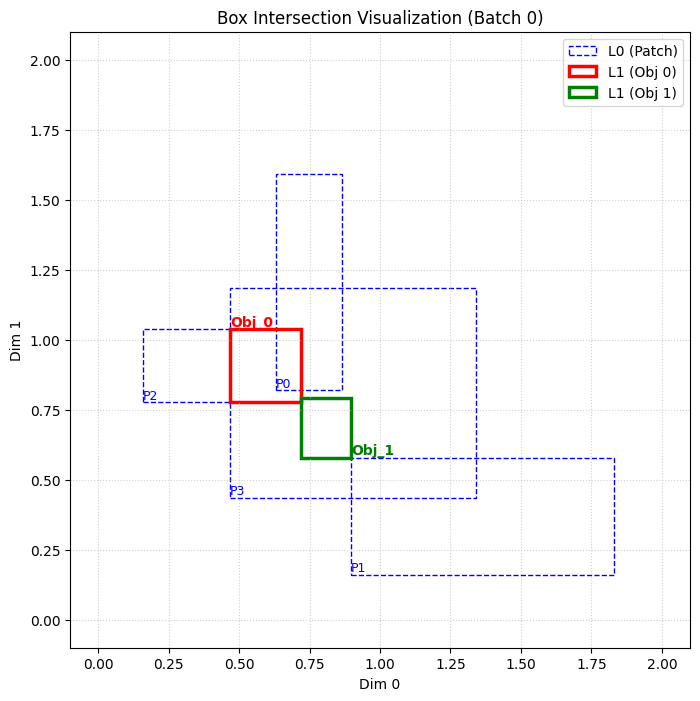

--- Adjacency Weights for Batch 0 ---
(Rows = L1 Objects, Cols = L0 Patches)
[[0.    0.    1.    1.   ]
 [0.125 1.    1.    1.   ]]


In [39]:
BATCH_SIZE = 1
DIM = 2
num_l0 = 4
num_l1 = 2

l0_mu_min = torch.rand(BATCH_SIZE, num_l0, DIM)
l0_mu_max = l0_mu_min + torch.rand(BATCH_SIZE, num_l0, DIM)
l0_beta_min = torch.rand(BATCH_SIZE, num_l0, DIM) * 0.05 + 0.01
l0_beta_max = torch.rand(BATCH_SIZE, num_l0, DIM) * 0.05 + 0.01

l0_box_dists = BoxEmbeddingDistribution(l0_mu_min, l0_mu_max, l0_beta_min, l0_beta_max)

adjacency_logits = torch.randn(BATCH_SIZE, num_l1, num_l0) * 5
# weights = torch.sigmoid(adjacency_logits)
# weights = torch.Tensor([[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0]])
weights = gumbel_sigmoid(adjacency_logits, temperature=0.1, hard=False)

w_expanded = weights.unsqueeze(-1)

# Box params shape: (B, N, D) -> (B, 1, N, D) to broadcast against M parents
mu_min_expanded = l0_box_dists.mu_min.unsqueeze(1)
mu_max_expanded = l0_box_dists.mu_max.unsqueeze(1)
beta_min_expanded = l0_box_dists.beta_min.unsqueeze(1)
beta_max_expanded = l0_box_dists.beta_max.unsqueeze(1)

# 3. Compute Effective Beta for Level 1 (Weighted Average)
# This determines the "sharpness" of the intersection.
# We add epsilon to sum_weights to avoid division by zero if all weights are 0.
eps = 1e-10
sum_weights = torch.sum(w_expanded, dim=2, keepdim=True) + eps

# Shape: (B, M, 1, D)
l1_beta_min = torch.sum(w_expanded * beta_min_expanded, dim=2, keepdim=True) / sum_weights
l1_beta_max = torch.sum(w_expanded * beta_max_expanded, dim=2, keepdim=True) / sum_weights

# 4. Gated LogSumExp for Min Coordinate (Intersection Min = Max of inputs)
# Formula: beta * log( Sum( w_i * exp(mu_i / beta) ) )
# We add eps to w_expanded inside the log to handle cases where weight is 0 (inactive constraint)
arg_min = torch.log(w_expanded + eps) + (mu_min_expanded / l1_beta_min)
l1_mu_min = l1_beta_min * torch.logsumexp(arg_min, dim=2, keepdim=True)

# 5. Gated SoftMin for Max Coordinate (Intersection Max = Min of inputs)
# Formula: -beta * log( Sum( w_i * exp(-mu_i / beta) ) )
arg_max = torch.log(w_expanded + eps) + (-mu_max_expanded / l1_beta_max)
l1_mu_max = -l1_beta_max * torch.logsumexp(arg_max, dim=2, keepdim=True)

# 6. Squeeze to get final Level 1 params: (BATCH_SIZE, num_l1, DIM)
l1_mu_min = l1_mu_min.squeeze(2)
l1_mu_max = l1_mu_max.squeeze(2)
l1_beta_min = l1_beta_min.squeeze(2)
l1_beta_max = l1_beta_max.squeeze(2)

# Create the Level 1 Distribution object
l1_box_dists = BoxEmbeddingDistribution(l1_mu_min, l1_mu_max, l1_beta_min, l1_beta_max)

plot_boxes(l0_box_dists, l1_box_dists, weights)


In [ ]:
l1_box_dists.beta_min, l1_box_dists.beta_max

In [ ]:
l0_box_dists.beta_min, l0_box_dists.beta_max

In [ ]:
weights.shape